# Upwork İş İlanları Sınıflandırması
## Ayham Assad (22040101099)

Proje Amacı: Fixed vs Hourly iş türlerini makine öğrenmesi modelleriyle sınıflandırmak.

Kullanılan Modeller:
- Gradient Boosting (GridSearchCV)
- Random Forest (GridSearchCV)
- XGBoost (GridSearchCV)
- MLP (PyTorch)
- LSTM (PyTorch)

Değerlendirme Metrikleri: Accuracy, Precision, Recall, F1, AUC

##  KÜTÜPHANELERİ YÜKLE

In [1]:
# =====================================================
# HÜCRE 1 – KÜTÜPHANELERİ YÜKLE
# Bu hücre:
# 1) Temel, sklearn, xgboost ve PyTorch kütüphanelerini yükler
# 2) Uyarı mesajlarını gizler
# =====================================================

import warnings
warnings.filterwarnings('ignore')

# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modelleri ve yardımcı fonksiyonlar
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report,
    precision_recall_fscore_support
)
from scipy.sparse import hstack
from xgboost import XGBClassifier

# PyTorch kütüphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Tüm kütüphaneler başarıyla yüklendi.")


Tüm kütüphaneler başarıyla yüklendi.


In [2]:
# =====================================================
# HÜCRE 2 – VERİ YÜKLEME VE HEDEF DEĞİŞKEN OLUŞTURMA
# Bu hücre:
# 1) CSV dosyasını okur
# 2) Başlığı boş satırları temizler
# 3) is_hourly sütununu 0/1 olarak kodlar
# =====================================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

# CSV dosyasını oku
df = pd.read_csv(csv_path, low_memory=False)

# Başlığı boş olan satırları kaldır
df = df.dropna(subset=["title"]).copy()

# Hedef değişken (is_hourly) kodlama fonksiyonu
def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    if s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

df["is_hourly"] = df["is_hourly"].apply(map_hourly)
df = df.dropna(subset=["is_hourly"]).copy()
df["is_hourly"] = df["is_hourly"].astype(int)

y = df["is_hourly"]

print(f" Veri Seti Boyutu: {df.shape}")
print("\n Sınıf Dağılımı:")
print(y.value_counts().sort_index())
print(f"\nFixed (0): {(y==0).sum():,} örnek")
print(f"Hourly (1): {(y==1).sum():,} örnek")


 Veri Seti Boyutu: (244827, 8)

 Sınıf Dağılımı:
is_hourly
0    103891
1    140936
Name: count, dtype: int64

Fixed (0): 103,891 örnek
Hourly (1): 140,936 örnek


In [3]:
# =====================================================
# HÜCRE 3 – SAYISAL ÖZELLİK MÜHENDİSLİĞİ
# Bu hücre:
# 1) Başlık uzunluğu ve kelime sayısını hesaplar
# 2) Bütçe ve saatlik ücret var mı bilgisini çıkarır
# 3) Ortalama saatlik ücret ve doldurulmuş bütçe değerlerini ekler
# 4) Ülke bilgisini kategorik → sayısal hale getirir
# =====================================================

# İş başlığının uzunluğu ve kelime sayısı
df["title_length"] = df["title"].astype(str).str.len()
df["word_count"] = df["title"].astype(str).str.split().str.len()

# Bütçe bilgisi var mı?
df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

# Ortalama saatlik ücret
df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1).fillna(0)
df["budget_filled"] = df["budget"].fillna(0)

# Ülke özelliği: en sık görülen 10 ülkeyi tut, diğerlerini "Other" yap
top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
)
df["country_grouped"] = df["country_grouped"].fillna("Unknown")

# Ülkeleri sayılara dönüştür (Label Encoding)
le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

print("Sayısal özellikler oluşturuldu")
print("\nÜretilen özellikler:")
print(" - title_length, word_count")
print(" - has_budget, has_hourly")
print(" - avg_hourly, budget_filled")
print(" - country_encoded")


Sayısal özellikler oluşturuldu

Üretilen özellikler:
 - title_length, word_count
 - has_budget, has_hourly
 - avg_hourly, budget_filled
 - country_encoded


In [4]:
# =====================================================
# HÜCRE 4 – METİN ÖZELLİKLERİ (TF-IDF)
# Bu hücre:
# 1) İş başlıklarını TF-IDF vektörlerine dönüştürür
# 2) 1500 en sık ve bilgilendirici kelimeyi kullanır
# =====================================================

tfidf = TfidfVectorizer(max_features=1500, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

print(f"TF-IDF matris boyutu: {X_text.shape}")
print(" - 1500 farklı kelime seçildi")
print(f" - {df.shape[0]:,} belge işlendi")


TF-IDF matris boyutu: (244827, 1500)
 - 1500 farklı kelime seçildi
 - 244,827 belge işlendi


In [5]:
# =====================================================
# HÜCRE 5 – TÜM ÖZELLİKLERİN BİRLEŞTİRİLMESİ
# Bu hücre:
# 1) Sayısal özellikleri seçer
# 2) TF-IDF matrisini bu sayısal özelliklerle birleştirir
# 3) Son X matrisini oluşturur
# =====================================================

numeric_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]

X_numeric = df[numeric_cols].values
X = hstack([X_text, X_numeric])

print("Tüm özellikler birleştirildi")
print("\n Son özellik matrisi:")
print(f" - Boyut: {X.shape[0]:,} örnek × {X.shape[1]} özellik")
print(" - 1500 TF-IDF + 7 sayısal = 1507 toplam özellik")


Tüm özellikler birleştirildi

 Son özellik matrisi:
 - Boyut: 244,827 örnek × 1507 özellik
 - 1500 TF-IDF + 7 sayısal = 1507 toplam özellik


In [6]:
# =====================================================
# HÜCRE 6 – TRAIN/TEST AYIRIMI
# Bu hücre:
# 1) X ve y'yi eğitim ve test setlerine böler
# 2) Stratify ile sınıf oranlarını korur
# =====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Veri bölünmesi tamamlandı")
print(f" Eğitim Seti: {X_train.shape[0]:,} örnek")
print(f" Test Seti:   {X_test.shape[0]:,} örnek")
print(" Sınıf dengesi korunmuştur.")


Veri bölünmesi tamamlandı
 Eğitim Seti: 195,861 örnek
 Test Seti:   48,966 örnek
 Sınıf dengesi korunmuştur.


In [7]:
# =====================================================
# HÜCRE 7 – SKLEARN MODELLERİ VE GRIDSEARCH (HIZLANDIRILMIŞ)
# Bu hücre:
# 1) Gradient Boosting
# 2) Random Forest
# 3) XGBoost
# modellerini cv=3 ve daraltılmış parametre aralıkları ile eğitir.
# =====================================================

print("\n" + "="*70)
print("SKLEARN MODELLERİ - GRIDSEARCHCV İLE HİPERPARAMETRE ARAMA")
print("="*70)

sklearn_results = []

# ------------- MODEL 1: GRADIENT BOOSTING -------------
print("\nGradient Boosting eğitiliyor...")

gb_params = {
    "n_estimators": [100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]        # 5,7 yerine 3,5
}

gb = GradientBoostingClassifier(random_state=42)

gb_grid = GridSearchCV(
    gb,
    gb_params,
    cv=3,             # 5 yerine 3 fold
    n_jobs=-1,
    scoring="f1"
)
gb_grid.fit(X_train, y_train)

y_pred_gb = gb_grid.best_estimator_.predict(X_test)
y_prob_gb = gb_grid.best_estimator_.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "Gradient Boosting",
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1": f1_score(y_test, y_pred_gb),
    "AUC": roc_auc_score(y_test, y_prob_gb)
})

print(" En iyi GB parametreleri:", gb_grid.best_params_)

# ------------- MODEL 2: RANDOM FOREST -------------
print("\nRandom Forest eğitiliyor...")

rf_params = {
    "n_estimators": [100],
    "max_depth": [15, 20],
    "min_samples_split": [5]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=3,
    n_jobs=-1,
    scoring="f1"
)
rf_grid.fit(X_train, y_train)

y_pred_rf = rf_grid.best_estimator_.predict(X_test)
y_prob_rf = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_prob_rf)
})

print(" En iyi RF parametreleri:", rf_grid.best_params_)

# ------------- MODEL 3: XGBOOST -------------
print("\nXGBoost eğitiliyor...")

xgb_params = {
    "n_estimators": [100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [5]        # 5,7 yerine 5
}

xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_grid = GridSearchCV(
    xgb,
    xgb_params,
    cv=3,
    n_jobs=-1,
    scoring="f1"
)
xgb_grid.fit(X_train, y_train)

y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
y_prob_xgb = xgb_grid.best_estimator_.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "AUC": roc_auc_score(y_test, y_prob_xgb)
})

print(" En iyi XGB parametreleri:", xgb_grid.best_params_)

# Sonuçları tablo olarak yazdır ve kaydet
sklearn_df = pd.DataFrame(sklearn_results).round(4)
print("\nSKLEARN MODELLER PERFORMANSI")
print(sklearn_df.to_string(index=False))

sklearn_df.to_csv("ayham_sklearn_models_fast.csv", index=False)
print("\nKaydedildi: ayham_sklearn_models_fast.csv")



SKLEARN MODELLERİ - GRIDSEARCHCV İLE HİPERPARAMETRE ARAMA

Gradient Boosting eğitiliyor...
 En iyi GB parametreleri: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Random Forest eğitiliyor...
 En iyi RF parametreleri: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}

XGBoost eğitiliyor...
 En iyi XGB parametreleri: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}

SKLEARN MODELLER PERFORMANSI
            Model  Accuracy  Precision  Recall  F1  AUC
Gradient Boosting       1.0        1.0     1.0 1.0  1.0
    Random Forest       1.0        1.0     1.0 1.0  1.0
          XGBoost       1.0        1.0     1.0 1.0  1.0

Kaydedildi: ayham_sklearn_models_fast.csv


In [8]:
# =====================================================
# HÜCRE 8 – PYTORCH İÇİN VERİ HAZIRLAMA
# Bu hücre:
# 1) X_train/X_test'i dense forma çevirir
# 2) StandardScaler ile ölçekler
# 3) PyTorch Dataset ve DataLoader oluşturur
# =====================================================

print("\n" + "="*70)
print("PYTORCH DERİN ÖĞRENME MODELLERİ")
print("="*70)

# Seyrek matristen dense matrise dönüşüm
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Özellikleri 0-1 aralığında ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("İşlemci:", device)

pytorch_results = []
loss_fn = nn.BCELoss()

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train_np.reshape(-1, 1))
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



PYTORCH DERİN ÖĞRENME MODELLERİ
İşlemci: cpu


In [9]:
# =====================================================
# HÜCRE 9 – PYTORCH MLP MODELİ
# Bu hücre:
# 1) MLP modelini tanımlar (256-128-64-1 yerine biraz daha hafif)
# 2) 5 epoch boyunca eğitir (20 yerine 5)
# 3) Test seti performansını hesaplar
# =====================================================

print("\n1) MLP (Multi-Layer Perceptron) eğitiliyor...")

class MLPModel(nn.Module):
    """
    Çok katmanlı sinir ağı (MLP) modeli.
    """
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)   # 256 → 128
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

mlp_model = MLPModel(X_train_scaled.shape[1]).to(device)
optim_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_model.train()
for epoch in range(5):   # 20 → 5
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_mlp.zero_grad()
        out = mlp_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_mlp.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp: {epoch_loss/len(train_loader):.4f}")

mlp_model.eval()
with torch.no_grad():
    y_prob_mlp = mlp_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()
    y_pred_mlp = (y_prob_mlp > 0.5).astype(int)

pytorch_results.append({
    "Model": "MLP",
    "Architecture": "128-64-1",
    "Accuracy": accuracy_score(y_test_np, y_pred_mlp),
    "Precision": precision_score(y_test_np, y_pred_mlp),
    "Recall": recall_score(y_test_np, y_pred_mlp),
    "F1": f1_score(y_test_np, y_pred_mlp),
    "AUC": roc_auc_score(y_test_np, y_prob_mlp)
})

print("MLP eğitimi tamamlandı.")



1) MLP (Multi-Layer Perceptron) eğitiliyor...
Epoch 1/5 - Ortalama Kayıp: 0.0370
Epoch 2/5 - Ortalama Kayıp: 0.0008
Epoch 3/5 - Ortalama Kayıp: 0.0006
Epoch 4/5 - Ortalama Kayıp: 0.0002
Epoch 5/5 - Ortalama Kayıp: 0.0001
MLP eğitimi tamamlandı.


In [10]:
# =====================================================
# HÜCRE 10 – PYTORCH LSTM MODELİ
# Bu hücre:
# 1) LSTM tabanlı modeli tanımlar
# 2) 5 epoch boyunca eğitir
# 3) Test verisi üzerinde performans metriklerini hesaplar
# =====================================================

print("\n2) LSTM (Long Short-Term Memory) eğitiliyor...")

class LSTMModel(nn.Module):
    """
    LSTM tabanlı model.
    Giriş: (batch_size, features) → (batch_size, 1, features)
    """
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            batch_first=True,
            num_layers=1   # 2 → 1 katman
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        x = self.fc(h[-1])
        return x

lstm_model = LSTMModel(X_train_scaled.shape[1]).to(device)
optim_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train()
for epoch in range(5):   # 20 → 5
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_lstm.zero_grad()
        out = lstm_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_lstm.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp: {epoch_loss/len(train_loader):.4f}")

lstm_model.eval()
with torch.no_grad():
    y_prob_lstm = lstm_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()
    y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

pytorch_results.append({
    "Model": "LSTM",
    "Architecture": "LSTM(64)-32-1",
    "Accuracy": accuracy_score(y_test_np, y_pred_lstm),
    "Precision": precision_score(y_test_np, y_pred_lstm),
    "Recall": recall_score(y_test_np, y_pred_lstm),
    "F1": f1_score(y_test_np, y_pred_lstm),
    "AUC": roc_auc_score(y_test_np, y_prob_lstm)
})

# PyTorch sonuçlarını tabloya çevirip kaydet
pytorch_df = pd.DataFrame(pytorch_results).round(4)
print("\nPYTORCH MODELLER PERFORMANSI")
print(pytorch_df.to_string(index=False))

pytorch_df.to_csv("ayham_pytorch_models_fast.csv", index=False)
print("\nKaydedildi: ayham_pytorch_models_fast.csv")



2) LSTM (Long Short-Term Memory) eğitiliyor...
Epoch 1/5 - Ortalama Kayıp: 0.0839
Epoch 2/5 - Ortalama Kayıp: 0.0004
Epoch 3/5 - Ortalama Kayıp: 0.0001
Epoch 4/5 - Ortalama Kayıp: 0.0000
Epoch 5/5 - Ortalama Kayıp: 0.0002

PYTORCH MODELLER PERFORMANSI
Model  Architecture  Accuracy  Precision  Recall    F1  AUC
  MLP      128-64-1    1.0000     1.0000  1.0000 1.000  1.0
 LSTM LSTM(64)-32-1    0.9989     0.9996  0.9984 0.999  1.0

Kaydedildi: ayham_pytorch_models_fast.csv


In [11]:
# =====================================================
# HÜCRE 11 – SINIF BAZLI PERFORMANS METRİKLERİ
# Bu hücre:
# 1) Her model için sınıf bazlı Precision, Recall ve F1 hesaplar
# 2) Sonuçları CSV dosyasına kaydeder
# =====================================================

class_results = []

for y_pred, name in [
    (y_pred_gb, "Gradient Boosting"),
    (y_pred_rf, "Random Forest"),
    (y_pred_xgb, "XGBoost"),
    (y_pred_mlp, "MLP"),
    (y_pred_lstm, "LSTM")
]:
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_test_np, y_pred, average=None, zero_division=0
    )
    for i in [0, 1]:
        class_results.append({
            "Model": name,
            "Sinif": "Fixed" if i == 0 else "Hourly",
            "Precision": round(prec[i], 4),
            "Recall": round(rec[i], 4),
            "F1-Score": round(f1[i], 4)
        })

class_df = pd.DataFrame(class_results)
print(class_df.to_string(index=False))

class_df.to_csv("ayham_class_wise_metrics_fast.csv", index=False)
print("\nKaydedildi: ayham_class_wise_metrics_fast.csv")


            Model  Sinif  Precision  Recall  F1-Score
Gradient Boosting  Fixed     1.0000  1.0000    1.0000
Gradient Boosting Hourly     1.0000  1.0000    1.0000
    Random Forest  Fixed     1.0000  1.0000    1.0000
    Random Forest Hourly     1.0000  1.0000    1.0000
          XGBoost  Fixed     1.0000  1.0000    1.0000
          XGBoost Hourly     1.0000  1.0000    1.0000
              MLP  Fixed     1.0000  1.0000    1.0000
              MLP Hourly     1.0000  1.0000    1.0000
             LSTM  Fixed     0.9979  0.9995    0.9987
             LSTM Hourly     0.9996  0.9984    0.9990

Kaydedildi: ayham_class_wise_metrics_fast.csv


##  GÖRSELLEŞTİRME - ROC CURVES

Kaydedildi: ayham_roc_curves_comparison_fast.png


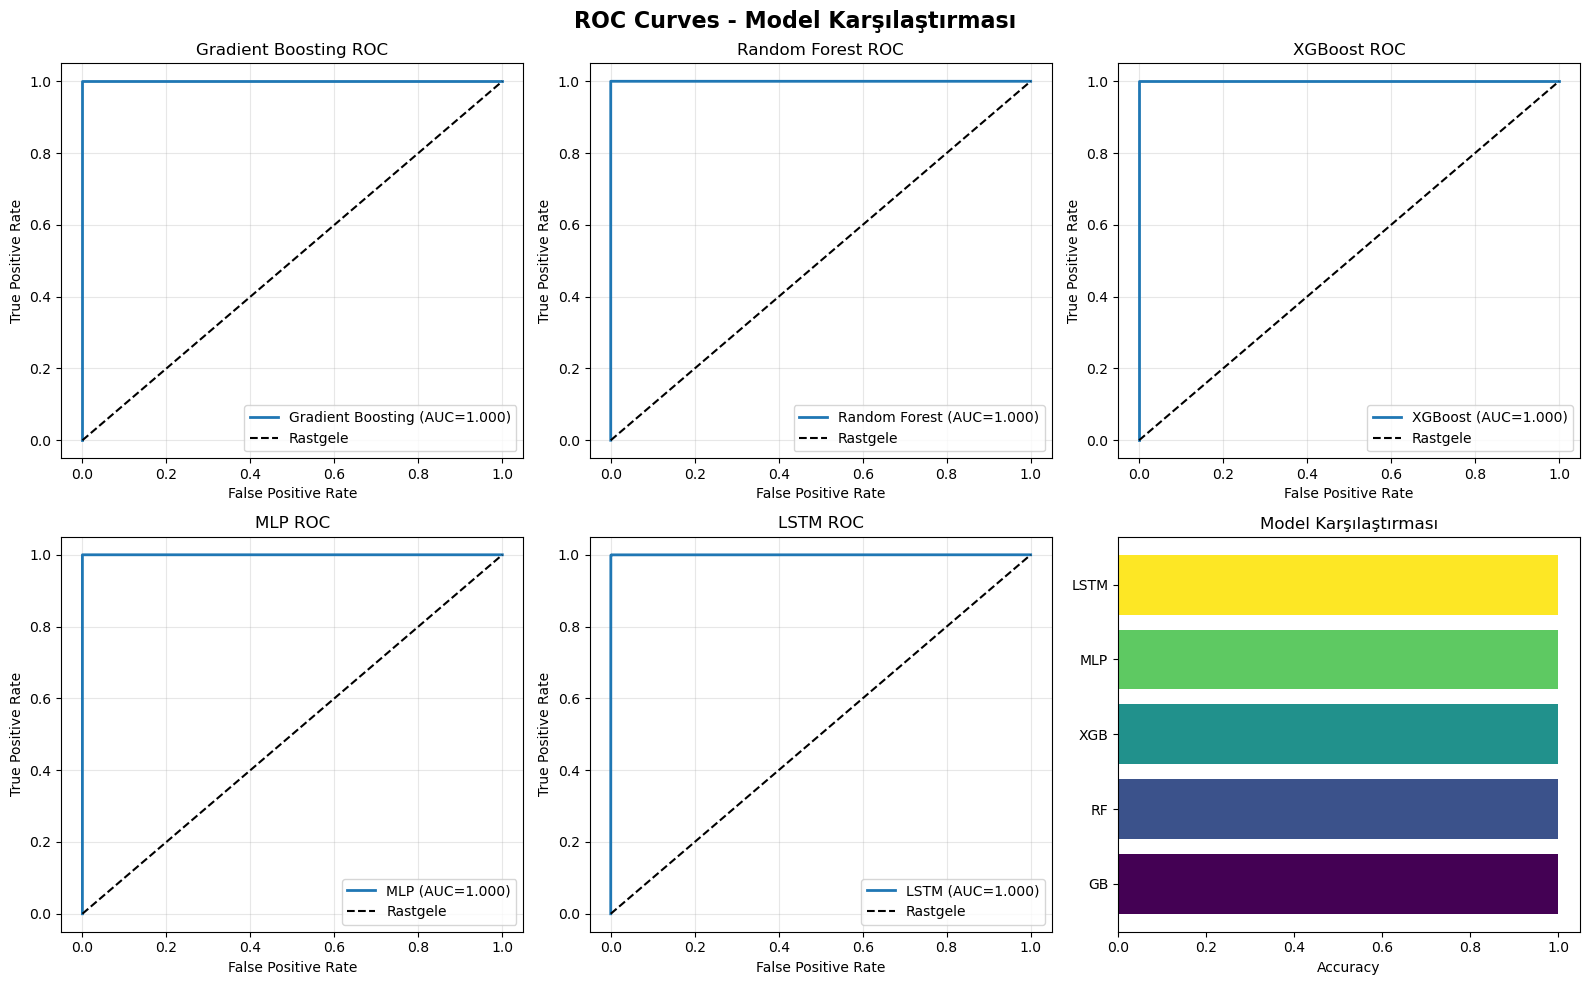

Kaydedildi: ayham_class_distribution.png


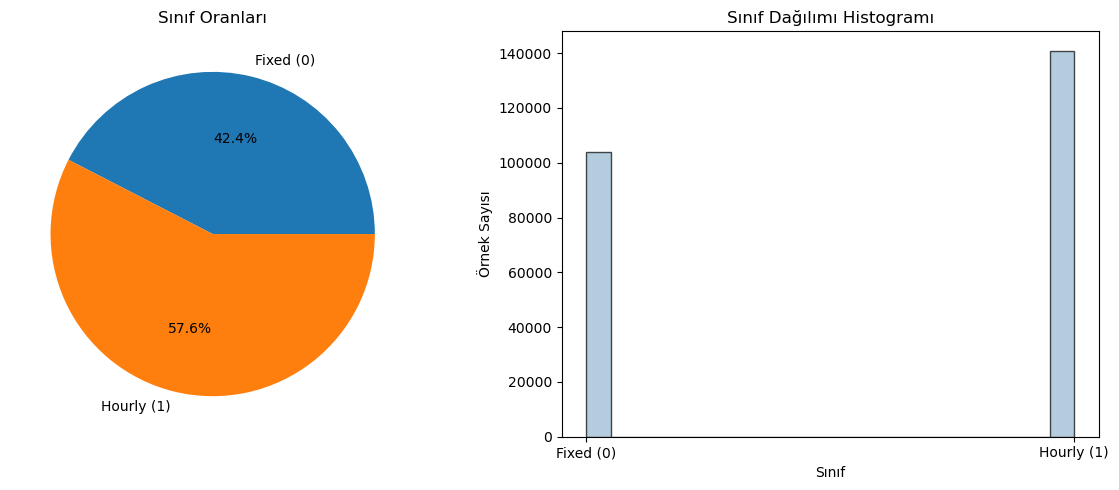


Ayham için proje çalışması tamamlandı.


In [12]:
# =====================================================
# HÜCRE 12 – ROC EĞRİLERİ VE SINIF DAĞILIMI GÖRSELLERİ
# Bu hücre:
# 1) Tüm modeller için ROC eğrilerini çizer
# 2) Modellerin doğruluk skorlarını bar grafik olarak gösterir
# 3) Sınıf dağılımını pie ve histogram ile görselleştirir
# =====================================================

# ROC eğrileri
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("ROC Curves - Model Karşılaştırması", fontsize=16, fontweight="bold")

for y_proba, label, ax in [
    (y_prob_gb, "Gradient Boosting", axes[0, 0]),
    (y_prob_rf, "Random Forest", axes[0, 1]),
    (y_prob_xgb, "XGBoost", axes[0, 2]),
    (y_prob_mlp, "MLP", axes[1, 0]),
    (y_prob_lstm, "LSTM", axes[1, 1])
]:
    fpr, tpr, _ = roc_curve(y_test_np, y_proba)
    auc = roc_auc_score(y_test_np, y_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], "k--", label="Rastgele")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{label} ROC")
    ax.legend()
    ax.grid(alpha=0.3)

# Doğruluk (Accuracy) bar grafiği
ax = axes[1, 2]
models_acc = [
    ("GB", accuracy_score(y_test_np, y_pred_gb)),
    ("RF", accuracy_score(y_test_np, y_pred_rf)),
    ("XGB", accuracy_score(y_test_np, y_pred_xgb)),
    ("MLP", accuracy_score(y_test_np, y_pred_mlp)),
    ("LSTM", accuracy_score(y_test_np, y_pred_lstm))
]
ax.barh(
    [m[0] for m in models_acc],
    [m[1] for m in models_acc],
    color=plt.cm.viridis(np.linspace(0, 1, len(models_acc)))
)
ax.set_xlabel("Accuracy")
ax.set_title("Model Karşılaştırması")

plt.tight_layout()
plt.savefig("ayham_roc_curves_comparison_fast.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: ayham_roc_curves_comparison_fast.png")
plt.show()

# Sınıf dağılımı görselleri
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sizes = pd.Series(y).value_counts().sort_index()

# Pie chart
axes[0].pie(
    sizes,
    labels=["Fixed (0)", "Hourly (1)"],
    autopct="%1.1f%%"
)
axes[0].set_title("Sınıf Oranları")

# Histogram
axes[1].hist(y, bins=20, color="#95B8D1", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Sınıf")
axes[1].set_ylabel("Örnek Sayısı")
axes[1].set_title("Sınıf Dağılımı Histogramı")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Fixed (0)", "Hourly (1)"])

plt.tight_layout()
plt.savefig("ayham_class_distribution.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: ayham_class_distribution.png")
plt.show()

print("\nAyham için proje çalışması tamamlandı.")


In [1]:
!pip install torch --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
